In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any, List
from opik import Opik
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
OPIK_RESPONSE_GENERATION_PROJECT_NAME = "LLMmark_evaluation"

EMPTY_PLACEHOLDER = '_EMPTY_FAILURE_'
TIMEOUT_PLACEHOLDER = '_TIMEOUT_FAILURE_'
OVERTHINK_PLACEHOLDER = '_OVERTHINK_FAILURE_'


/home/cim/LLMmark/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_and_identify_failures(df: pd.DataFrame) -> pd.DataFrame:
    """
    Identifies failed responses in the DataFrame based on timeout or token limit.
    """
    timeout = 120
    
    is_empty = df['span_output_raw_answer'].fillna('').str.strip() == ''
    
    # It is considered timeout if the response time is > 120 seconds and the answer is empty
    # Some models like gemma3n can take more than 120 seconds because of the memory limit (we use swap memory)
    is_timeout = (df['response_time'] >= timeout).fillna(False) & is_empty
    
    
    # If the raw_answer contains <think>, we consider that it has reached the token limit or an infinite loop
    is_token_limit_hit = df['span_output_raw_answer'].str.contains('<think>', na=False)
    
    df['is_failure'] = is_timeout | is_token_limit_hit | is_empty
    
    conditions = [
        is_timeout,
        is_token_limit_hit,
        is_empty
    ]
    
    placeholders = [
        TIMEOUT_PLACEHOLDER,
        OVERTHINK_PLACEHOLDER,
        EMPTY_PLACEHOLDER
    ]
    
    # Apply the failure placeholders in the answer column, else keep the original raw answer
    df['answer'] = np.select(conditions, placeholders, default=df['span_output_raw_answer'])

    failure_count = df['is_failure'].sum()
    if failure_count > 0:
        print(f"INFO: Total of {failure_count} failed responses (timeout, empty answer or infinite loop).")

    return df


def parse_model_info(model_name: str, tags: List[str]) -> Dict[str, str]:
    """
    Parses model ID, display name, and size from the model name and tags.
    Adjust this function based on your actual model naming conventions.
    """
    model_id = model_name

    match = re.search(r':([\d\.]+)b', model_name)
    if match:
        model_size = match.group(1) + "B"

    return {
        "model_id": model_id,
    }

def get_opik_flat_data_for_csv(project_name: str = OPIK_RESPONSE_GENERATION_PROJECT_NAME) -> List[Dict[str, Any]]:
    """Fetch and flatten Opik trace data for CSV export.

    Args:
        project_name (str, optional): The name of the Opik project to fetch data from. Defaults to OPIK_RESPONSE_GENERATION_PROJECT_NAME.

    Returns:
        List[Dict[str, Any]]: A list of dictionaries containing the flattened trace data.
    """
    client = Opik()
    flat_data = []

    print(f"Fetching traces from project: {project_name}...")

    traces = client.search_traces(
        project_name=project_name,
        max_results=100000,
    )

    if not traces:
        print(f"No traces found in project '{project_name}'. Please check the project name and your Opik configuration.")
        return []
    
    traces = [trace for trace in traces if trace.name is not None]

    for i, trace in enumerate(traces):
        print(f"Processing trace {i+1}/{len(traces)}: {trace.name} ({trace.id})")

        trace_content = client.get_trace_content(trace.id)
        spans = client.search_spans(project_name=project_name, trace_id=trace.id)

        if not spans:
            print(f"  No spans found for trace {trace.id}. Skipping.")
            continue

        trace_flat_metadata = {
            "trace_id": trace.id,
            "run_name": trace_content.metadata.get("run_name"),
            "model_id": trace_content.metadata.get("model_id"),
            **{f"trace_meta_{k.replace('.', '_')}": v for k, v in (trace_content.metadata or {}).items()}
        }

        for j, span in enumerate(spans):
            feedback_scores_dict = {score.name: score for score in span.feedback_scores} if span.feedback_scores else {}

            all_contained_score = feedback_scores_dict.get('all_contained')
            contains_percentage_score = feedback_scores_dict.get('contains_percentage')
            geval_score_obj = feedback_scores_dict.get('geval_score')
            rouge1_score_obj = feedback_scores_dict.get('rouge1_f1')
            rouge2_score_obj = feedback_scores_dict.get('rouge2_f1')
            rougeL_score_obj = feedback_scores_dict.get('rougeL_f1')
            
            span_data_row = {
                "span_id": span.id,
                "span_name": span.name,
                "all_contained": all_contained_score.value if all_contained_score else None,
                "contains_percentage": contains_percentage_score.value if contains_percentage_score else None,
                "geval_score": geval_score_obj.value if geval_score_obj else None,
                "geval_score_reasoning": geval_score_obj.reason if geval_score_obj else None,
                "rouge1_score": rouge1_score_obj.value if rouge1_score_obj else None,
                "rouge2_score": rouge2_score_obj.value if rouge2_score_obj else None,
                "rougeL_score": rougeL_score_obj.value if rougeL_score_obj else None,
            }
            
            combined_row = {**span_data_row, **trace_flat_metadata}
            flat_data.append(combined_row)

    return flat_data

def get_dataframe_from_csv(csv_filename: str = "opik_determinism_data.csv", output_dir = '../../../data/evaluation') -> pd.DataFrame:
    """Reads a CSV file into a DataFrame.

    Args:
        csv_filename (str, optional): The name of the CSV file to read. Defaults to "opik_determinism_data.csv".

    Returns:
        pd.DataFrame: The DataFrame containing the CSV data.
    """
    output_dir = output_dir
    output_path = os.path.join(output_dir, csv_filename)
    
    if not os.path.exists(output_path):
        print(f"CSV file {output_path} does not exist.")
        return pd.DataFrame()
    
    df = pd.read_csv(output_path, encoding='utf-8')
    print(f"DataFrame loaded from {output_path} with shape: {df.shape}")
    
    return df


def filter_and_save_dataframe(
    df: pd.DataFrame, 
    csv_filename: str = "opik_evaluation.csv"
) -> None:
    """Filters the DataFrame by temperature and saves it to a CSV file.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        csv_filename (str, optional): The name of the CSV file to save. Defaults to "opik_evaluation.csv".
    """
    if df.empty:
        print("\nInput DataFrame is empty. No CSV file will be created.")
        return

    filtered_df = df.copy()


    output_filename = csv_filename
    output_dir = '../../../data/evaluation'
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_filename)
    
    filtered_df.to_csv(output_path, index=False, encoding='utf-8')

    print(f"\nSuccessfully extracted data and saved to {output_path}")
   




In [3]:
all_opik_data = None

In [4]:
# Get all the data of Opik determinism project
all_opik_data = get_opik_flat_data_for_csv()


Fetching traces from project: LLMmark_evaluation...


Processing trace 1/1490: eval_gemma3n:e4b_q10 (0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9)
Processing trace 2/1490: eval_gemma3n:e4b_q9 (0197ee20-9c48-7b4c-ab1a-194709513a78)
Processing trace 3/1490: eval_gemma3n:e4b_q8 (0197ee20-826c-7893-a032-5b5748fe60b6)
Processing trace 4/1490: eval_gemma3n:e4b_q7 (0197ee20-6a6b-7df6-a6f0-4ef21c2549c4)
Processing trace 5/1490: eval_gemma3n:e4b_q6 (0197ee20-522c-722c-b54f-b06bc39e0e3c)
Processing trace 6/1490: eval_gemma3n:e4b_q5 (0197ee20-360e-72f0-8285-05923c380824)
Processing trace 7/1490: eval_gemma3n:e4b_q4 (0197ee20-18c9-7e01-b8de-47cefd671433)
Processing trace 8/1490: eval_gemma3n:e4b_q3 (0197ee1f-fdb7-7805-9fa7-f2c45be6a8b3)
Processing trace 9/1490: eval_gemma3n:e4b_q2 (0197ee1f-e672-7c3d-ba04-59c27e3aa77a)
Processing trace 10/1490: eval_gemma3n:e4b_q1 (0197ee1f-c790-7f97-8db3-ae9e7454b3c3)
Processing trace 11/1490: eval_qwen3:4b_q10 (0197ee1d-b0c7-7319-a064-92f67114a841)
Processing trace 12/1490: eval_qwen3:4b_q9 (0197ee1d-9161-7c15-9703-82fb117

In [5]:

if all_opik_data:
    full_df = pd.DataFrame(all_opik_data).copy()
    print(f"\nFull DataFrame loaded with shape: {full_df.shape}")
    
    # Save full dataframe
    filter_and_save_dataframe(full_df)

else:
    print("No data fetched from Opik to create any CSV files.")


Full DataFrame loaded with shape: (1490, 15)

Successfully extracted data and saved to ../../../data/evaluation/opik_evaluation.csv


In [6]:
csv_filename="opik_evaluation.csv"
gen_responses_df = get_dataframe_from_csv(csv_filename=csv_filename)
df_evaluation = gen_responses_df.copy()
df_evaluation.head()

df_evaluation['run_name'] 

DataFrame loaded from ../../../data/evaluation/opik_evaluation.csv with shape: (1490, 15)


0       run_1048
1       run_1048
2       run_1048
3       run_1048
4       run_1048
          ...   
1485     run_446
1486     run_998
1487     run_303
1488     run_446
1489     run_303
Name: run_name, Length: 1490, dtype: object

In [7]:
csv_filename="opik_response_generation.csv"
output_dir='../../../data/response_generation'
gen_responses_df = get_dataframe_from_csv(csv_filename=csv_filename, output_dir=output_dir)
df_responses = gen_responses_df.copy()

# pasara a minúsculas y quitar espacios en blanco
df_responses['model_display_name'] = df_responses['model_display_name'].str.lower()
df_responses['model_display_name'] = df_responses['model_display_name'].str.strip()

df_evaluation['model_display_name'] = df_evaluation['model_id'].str.lower()

df_responses['run_name'] = ['_'.join(str(nombre).split('_')[:2]) for nombre in df_responses['run_name']]

# # unificar por run_name y model_id
df = pd.merge(df_evaluation, df_responses, on=['run_name', 'model_display_name'], how='left', suffixes=('_eval', '_response'))


# correct answers if:
# - geval_score >= 0.8
# - rouge1_score >= 0.8
# - rougeL_score >= 0.8
df['is_correct'] = (
    (df['geval_score'] >= 0.8) & 
    (df['contains_percentage'] >= 80)
)


# df.columns

df.head()



DataFrame loaded from ../../../data/response_generation/opik_response_generation.csv with shape: (11792, 23)


,span_id_eval,span_name_eval,all_contained,contains_percentage,geval_score,geval_score_reasoning,rouge1_score,rouge2_score,rougeL_score,trace_id_eval,...,num_runs_per_question,model_source,temperature,top_p,exercise,question_type,model_id_response,is_failure,answer,is_correct
0,0197ee20-d906-742f-8f2a-7b829e31ed95,run_1,0.0,0.0,0.0,"The model answer is missing. Therefore, it ca...",0.0,0.0,0.0,0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9,...,1.0,local,0.0,0.1,exam_01_oa,open_answer,run_1048_gemma3n:e4b,True,_TIMEOUT_FAILURE_,False
1,0197ee20-d906-742f-8f2a-7b829e31ed95,run_1,0.0,0.0,0.0,"The model answer is missing. Therefore, it ca...",0.0,0.0,0.0,0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9,...,1.0,local,0.0,0.1,exam_01_oa,open_answer,run_1048_gemma3n:e4b,True,_TIMEOUT_FAILURE_,False
2,0197ee20-d906-742f-8f2a-7b829e31ed95,run_1,0.0,0.0,0.0,"The model answer is missing. Therefore, it ca...",0.0,0.0,0.0,0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9,...,1.0,local,0.0,0.1,exam_01_oa,open_answer,run_1048_gemma3n:e4b,False,El texto proporcionado explica la conversión d...,False
3,0197ee20-d906-742f-8f2a-7b829e31ed95,run_1,0.0,0.0,0.0,"The model answer is missing. Therefore, it ca...",0.0,0.0,0.0,0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9,...,1.0,local,0.0,0.1,exam_01_oa,open_answer,run_1048_gemma3n:e4b,True,_TIMEOUT_FAILURE_,False
4,0197ee20-d906-742f-8f2a-7b829e31ed95,run_1,0.0,0.0,0.0,"The model answer is missing. Therefore, it ca...",0.0,0.0,0.0,0197ee20-bb7a-7f5f-8142-2ec68ef7a8f9,...,1.0,local,0.0,0.1,exam_01_oa,open_answer,run_1048_gemma3n:e4b,False,Para encontrar la representación binaria del n...,False


In [8]:


def map_prompt_technique(tech_code):
    if 'S' in str(tech_code): return 'Standard'
    elif 'R' in str(tech_code): return 'Reasoning'
    elif 'D' in str(tech_code): return 'Definition-Based'
    else: return 'Unknown'
df['prompt_technique_full'] = df['prompting_tech'].apply(map_prompt_technique)

correct_counts = df.groupby(['model_id', 'prompt_technique_full', 'question_type'])['is_correct'].sum().reset_index()
correct_counts = correct_counts.rename(columns={'is_correct': 'Respuestas Correctas'})

incorrect_counts = df.groupby(['model_id', 'prompt_technique_full', 'question_type'])['is_correct'].apply(lambda x: (~x).sum()).reset_index()


total_counts = df.groupby(['model_id', 'prompt_technique_full', 'question_type']).size().reset_index(name='Total Respuestas')


print(f"----- Total correct responses: {correct_counts['Respuestas Correctas'].sum()}")
print(f"----- Total incorrect responses: {incorrect_counts['is_correct'].sum()}")
print(f"----- Total responses: {total_counts['Total Respuestas'].sum()}")



sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=correct_counts,
    x='model_id',
    y='Respuestas Correctas',
    hue='prompt_technique_full',
    col='question_type',
    kind='bar',
    height=7,
    aspect=1.2,
    palette={'Definition-Based': '#C85C6D', 'Reasoning': '#A8D8D7', 'Standard': '#232323'},
)

sns.move_legend(
    g, "upper center",
    bbox_to_anchor=(.5, 1.15),
    ncol=3,  
    title='Técnica de Prompt', 
    frameon=False, 
    fontsize=12
)

g.fig.suptitle('Conteo de Respuestas Correctas por Modelo, Técnica de Prompt y Tipo de Pregunta',
               fontsize=18, weight='bold', y=1.25)

g.set_axis_labels('Modelos', 'Número de Respuestas Correctas')
g.set_titles(col_template="{col_name}", size=14)
g.set_xticklabels(rotation=45, horizontalalignment='right')

sns.despine()

plt.show()

KeyError: 'model_id'

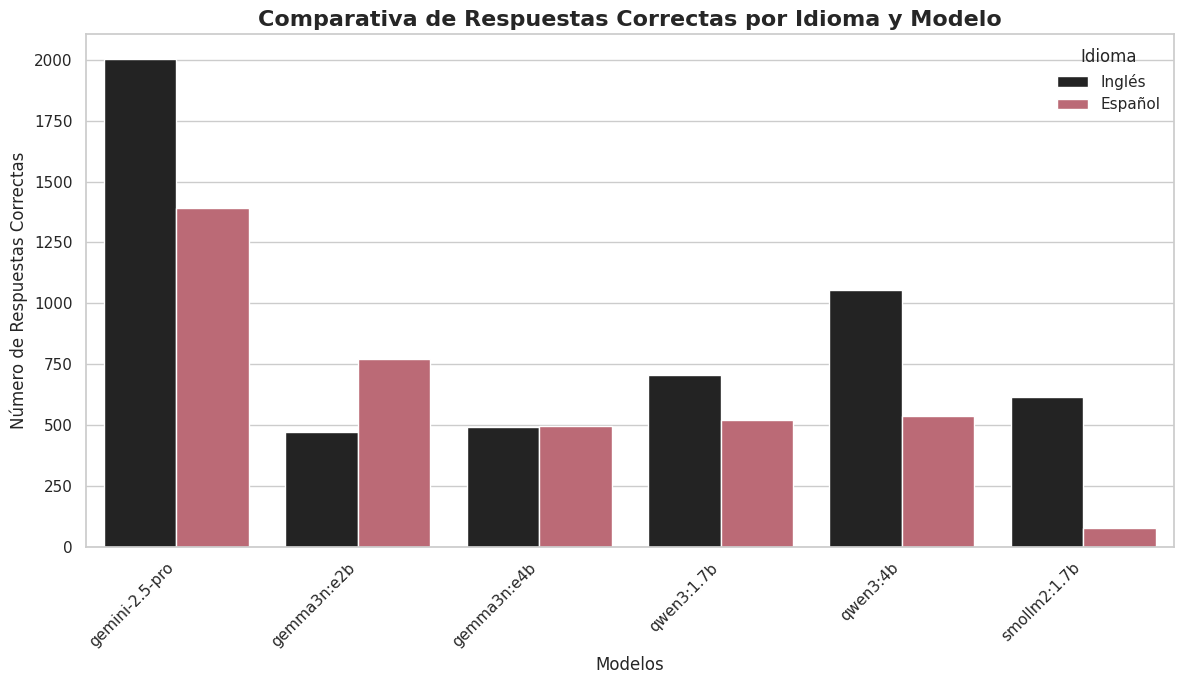

In [ ]:

lang_correct_counts = df.groupby(['model_id', 'language'])['is_correct'].sum().reset_index()
lang_correct_counts = lang_correct_counts.rename(columns={'is_correct': 'Respuestas Correctas'})

lang_correct_counts['Idioma'] = lang_correct_counts['language'].map({
    'en': 'Inglés',
    'es': 'Español'
})

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

sns.barplot(
    data=lang_correct_counts,
    x='model_id',
    y='Respuestas Correctas',
    hue='Idioma',
    palette={'Inglés': '#232323', 'Español': '#C85C6D'}
)

plt.title('Comparativa de Respuestas Correctas por Idioma y Modelo', fontsize=16, weight='bold')
plt.xlabel('Modelos', fontsize=12)
plt.ylabel('Número de Respuestas Correctas', fontsize=12)

plt.legend(title='Idioma', frameon=False, fontsize=11)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()